In [1]:
# SRGAN pytorch - celeba dataset 

# SRGAN이란 화질을 높이기 위해 제안된 모델, 특징 공간 상의 점을 입력으로 받는 GAN과 달리 
# SRGAN은 이미지를 입력으로 받는다. 
# 생성자는 이미지로부터 특징 추출, 추출된 특징을 바탕으로 해상도를 높인 이미지를 출력으로 내보냄 



In [2]:
# 데이터셋 정의 
import glob 
import torchvision.transforms as tf 

from torch.utils.data.dataset import Dataset 
from PIL import Image 

class CelebA(Dataset):
    def __init__(self):
        self.imgs = glob.glob('./dataset/img_align_celeba/*.jpg')

        # 정규화 평균, 공분산 
        mean_std = (0.5, 0.5, 0.5)

        # 입력용 이미지 
        self.low_res_tf = tf.Compose([
            tf.Resize((32, 32)),
            tf.ToTensor(),
            tf.Normalize(mean_std, mean_std)
        ])

        # 정답용 이미지 
        self.high_res_tf = tf.Compose([
            tf.Resize((64,64)),
            tf.ToTensor(),
            tf.Normalize(mean_std, mean_std)
        ])

    def __len__(self):
        return len(self.imgs) # 이미지 개수 반환 
    
    def __getitem__(self, i):
        img = Image.open(self.imgs[i])

        # 저화질 이미지 입력 
        img_low_res = self.low_res_tf(img)

        # 고화질 이미지 정답
        img_high_res = self.high_res_tf(img)

        return [img_low_res, img_high_res]

In [3]:
# SRGAN 생성자 정의 
import torch.nn as nn 

# 생성자 기본 블록
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channles):
        super(ResidualBlock, self).__init__()

        # 생성자 구성요소 정의
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channles, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channles),
            nn.PReLU(),
            nn.Conv2d(out_channles, out_channles, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channles)
        )

    def forward(self, x):
        x_ = x
        x = self.layers(x)

        # 합성곱층 거친 후 입력 텐서와 더하기
        x = x_ + x 

        return x
    
# 업샘플링 정의 
class UpSample(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.PReLU()
        )

# 생성자 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 첫 번째 합성곱층 
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),

            nn.PReLU()
        )

        self.res_blocks = nn.Sequential(
            ResidualBlock(in_channels=64, out_channles=64),
            ResidualBlock(in_channels=64, out_channles=64),
            ResidualBlock(in_channels=64, out_channles=64),
        )

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 업샘플링 
        self.upsample_blocks = nn.Sequential(
            UpSample(in_channels=64, out_channels=256)
        )
        
        # 합성곱
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.conv1(x)

        x_ = x

        x = self.res_blocks(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x+x_ 

        x = self.upsample_blocks(x)
        x = self.conv3(x)

        return x

In [9]:
# 판별자 기본 블록 정의
import torch 
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
    
    def forward(self, x):
        return self.layers(x)
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )

        self.blocks = DiscBlock(in_channels=64, out_channels=64)

        self.fc1 = nn.Linear(65536, 1024)
        self.activation = nn.LeakyReLU()
        self.fc2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.blocks(x)

        x = torch.flatten(x,start_dim=1)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [10]:
# 특징추출기 정의
import torch 
from torchvision.models.vgg import vgg19

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        vgg19_model = vgg19(pretrained=True)

        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:9])

    def forward(self, img):
        return self.feature_extractor(img)

In [11]:
# 학습 루프
import tqdm 

from torch.utils.data.dataloader import DataLoader 
from torch.optim.adam import Adam 

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = CelebA()
batch_size=8
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 생성자와 판별자 정의
G = Generator().to(device)
D = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

# 학습 루프 정의
for epoch in range(1):
    iterator = tqdm.tqdm(loader)

    for i, (low_res, high_res) in enumerate(iterator):
        # 기울기 초기화 
        G_optim.zero_grad()
        D_optim.zero_grad()

        # 진짜 이미지 가짜 이미지 정답
        label_true = torch.ones(batch_size, dtype=torch.float32).to(device)
        label_false = torch.zeros(batch_size, dtype=torch.float32).to(device)

        # 생성자 학습 
        fake_hr = G(low_res.to(device))
        GAN_loss = nn.MSELoss()(D(fake_hr), label_true)

        # CNN 특징 추출기로부터 추출된 특징 비교
        # 가짜 이미지 특징 추출
        fake_features = feature_extractor(fake_hr)
        # 진짜 이미지 특징 추출
        real_features = feature_extractor(high_res.to(device))
        # 둘의 차이 비교
        content_loss = nn.L1Loss()(fake_features, real_features)

        # 생성자 손실 정의 
        loss_G = content_loss + 0.001+GAN_loss
        loss_G.backward()
        G_optim.step()

        # 판별자 학습 
        # 진짜 이미지 손실
        real_loss = nn.MSELoss()(D(high_res.to(device)), label_true)
        # 가짜 이미지 손실
        fake_loss = nn.MSELoss()(D(fake_hr.detach()), label_false)
        # 손실 평균값 최종 오차 설정
        loss_D = (real_loss + fake_loss) / 2
        # 오차 역전파
        loss_D.backward()
        D_optim.step()

        iterator.set_description(f"epoch:{epoch} G_loss:{GAN_loss} D_loss:{loss_D}")

torch.save(G.state_dict(), "SRGAN_G.pth")
torch.save(D.state_dict(), "SRGAN_D.pth")

c:\Users\Lee\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lee\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Lee/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%
  0%|          | 0/25325 [00:00<?, ?it/s]c:\Users\Lee\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


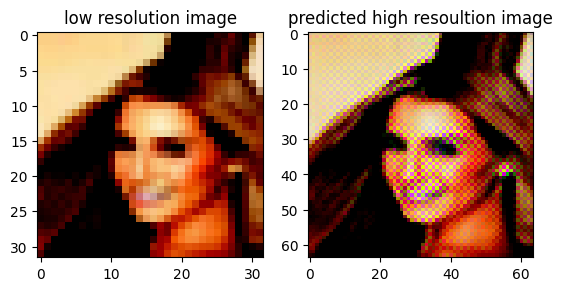

In [13]:
# 모델 성능 평가
import matplotlib.pyplot as plt 

G.load_state_dict(torch.load("SRGAN_G.pth", map_location=device))

with torch.no_grad():
    low_res, high_res = dataset[0]

    # 생성자 입력 
    input_tensor = torch.unsqueeze(low_res, dim=0).to(device)

    # 생성자 생성 고화질 이미지 
    pred = G(input_tensor)
    pred = pred.squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()

    # 저화질 ㅇ미ㅣ지 채널 차원 마지막으로 
    low_res = low_res.permute(1,2,0).numpy()

    # 저화질 입력 생성자 고화질 이미지 비교 
    plt.subplot(1,2,1)
    plt.title("low resolution image")
    plt.imshow(low_res)
    plt.subplot(1,2,2)
    plt.imshow(pred)
    plt.title("predicted high resoultion image")
    plt.show()
